In [1]:
import pandas as pd
import numpy as np
import psycopg2
import pyodbc
import mysql.connector
import json
import matplotlib.pyplot as plt
import seaborn as sns
from decimal import Decimal

import requests
import datetime
from tqdm import tqdm

In [2]:
pyodbc.drivers()

['MySQL']

### Redshift Connection

In [3]:
# Redshift 연결 정보
host=''
dbname=''
user=''
password=''
port=''

In [4]:
# Redshift에 연결
conn = psycopg2.connect(
    host=host,
    dbname=dbname,
    user=user,
    password=password,
    port=port
)

### Data Load1

#### MySQL

In [5]:
# 커서 생성
cursor = conn.cursor()
# SQL 쿼리 실행 (예시: frigga_sample 테이블에서 모든 데이터를 조회)
cursor.execute("""
                SELECT
                    *
                FROM "data_analysis_db"."da_schema"."v_aws_stn_distance_minmax"
                ORDER BY min_dist DESC
                ;
               """)

# 결과 가져오기
rows = cursor.fetchall()

cursor.close()
conn.close()

In [6]:
# 컬럼명 리스트 정의
columns = ['from_stn', 'from_nm', 'min_dist', 'min_to', 'min_nm', 'max_dist', 'max_to', 'max_nm']

# rows를 DataFrame으로 변환
aws_stn = pd.DataFrame(rows, columns=columns)

# 데이터프레임 확인
print("데이터프레임 크기:", aws_stn.shape)
print("\n처음 5행 데이터:")
print(aws_stn.head())

데이터프레임 크기: (741, 8)

처음 5행 데이터:
   from_stn from_nm  min_dist  min_to min_nm  max_dist  max_to max_nm
0        96      독도     89.95     115    울릉도    705.69     303    가거도
1       501     대연평     43.70     656    볼음도    546.70      96     독도
2       303     가거도     40.36     797    하태도    705.69      96     독도
3       229  북격렬비도*     39.33     663    목덕도    564.91      96     독도
4       797     하태도     33.76     798     홍도    671.34      96     독도


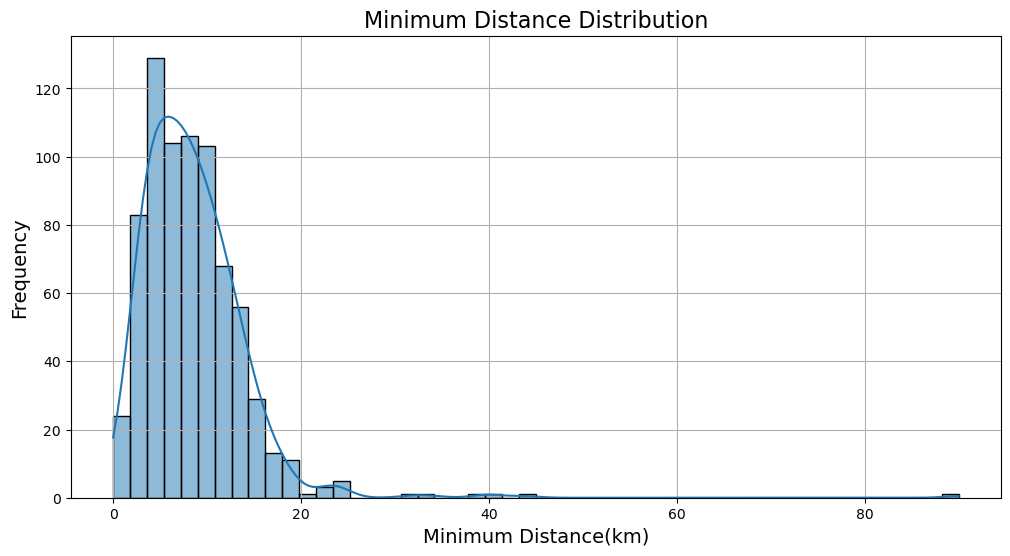

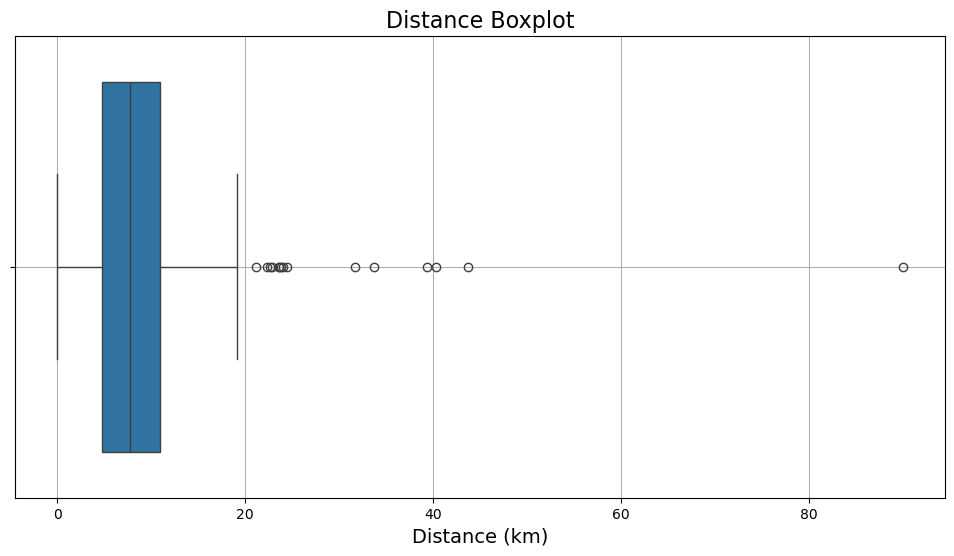

거리의 기본 통계량:
count    741.000000
mean       8.481012
std        5.842091
min        0.000000
25%        4.760000
50%        7.730000
75%       10.980000
max       89.950000
Name: min_dist, dtype: float64


In [9]:
# 거리 분포 확인을 위한 히스토그램
plt.figure(figsize=(12, 6))
sns.histplot(aws_stn['min_dist'], bins=50, kde=True)  # kde=True로 커널 밀도 추정 추가
plt.title('Minimum Distance Distribution', fontsize=16)
plt.xlabel('Minimum Distance(km)', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.grid(True)
plt.show()

# 거리 분포 확인을 위한 박스플롯
plt.figure(figsize=(12, 6))
sns.boxplot(x=aws_stn['min_dist'])
plt.title('Distance Boxplot', fontsize=16)
plt.xlabel('Distance (km)', fontsize=14)
plt.grid(True)
plt.show()

# 기본 통계량 출력
distance_stats = aws_stn['min_dist'].describe()
print("거리의 기본 통계량:")
print(distance_stats)

## Python Case

#### 두 지점간의 거리 구하는 공식(python code)

In [7]:
# Haversine 공식을 사용하여 두 지점 간의 거리 계산 함수
def haversine(lat1, lon1, lat2, lon2):
    # Decimal을 float으로 변환
    lat1, lon1, lat2, lon2 = map(float, [lat1, lon1, lat2, lon2])
    
    R = 6371  # 지구의 반지름 (킬로미터)
    phi1 = np.radians(lat1)
    phi2 = np.radians(lat2)
    delta_phi = np.radians(lat2 - lat1)
    delta_lambda = np.radians(lon2 - lon1)

    a = np.sin(delta_phi / 2)**2 + np.cos(phi1) * np.cos(phi2) * np.sin(delta_lambda / 2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))

    return R * c  # 거리 반환 (킬로미터)

In [ ]:
# 거리 계산을 위한 빈 리스트 생성
distances = []

# 각 지점 간의 거리 계산
for i in range(len(aws_stn)):
    for j in range(len(aws_stn)):
        if i != j:  # 같은 지점 간의 거리는 제외
            distance = haversine(aws_stn['lat'].iloc[i], aws_stn['lon'].iloc[i],
                                  aws_stn['lat'].iloc[j], aws_stn['lon'].iloc[j])
            distances.append((aws_stn.index[i], aws_stn.index[j], distance))

# 거리 정보를 데이터프레임으로 변환
distance_df = pd.DataFrame(distances, columns=['from', 'to', 'distance'])

# 각 지점별 min, max 거리 및 해당 지점 추출
min_max_distances = distance_df.groupby('from').agg(
    min_distance=('distance', 'min'),
    max_distance=('distance', 'max')
).reset_index()

# 최소 거리와 최대 거리의 지점 찾기
min_max_distances['min_to'] = min_max_distances.apply(
    lambda row: distance_df[(distance_df['from'] == row['from']) & (distance_df['distance'] == row['min_distance'])]['to'].values[0],
    axis=1
)

min_max_distances['max_to'] = min_max_distances.apply(
    lambda row: distance_df[(distance_df['from'] == row['from']) & (distance_df['distance'] == row['max_distance'])]['to'].values[0],
    axis=1
)

# 결과 출력
print("각 AWS 지점별 최소 및 최대 거리와 해당 지점:")
print(min_max_distances)